In [2]:
import sqlite3
import pandas as pd

conn = sqlite3.connect('../data/nfp2/nfp2.db')  # Adjust the path to your database file

# Step 2 & 3: Query the database and load the data into a pandas DataFrame
query = "SELECT * FROM stellarators"  # Adjust your query as needed
data_df = pd.read_sql_query(query, conn)

In [3]:
from sklearn.model_selection import train_test_split, GridSearchCV

data_df_clean = data_df.dropna(subset=['quasisymmetry'])

X = data_df_clean[['rbc_1_0', 'rbc_m1_1', 'rbc_0_1', 'rbc_1_1','zbs_1_0', 'zbs_m1_1', 'zbs_0_1', 'zbs_1_1']] 
Y = data_df_clean[['quasisymmetry', 'quasiisodynamic', 'rotational_transform', 'inverse_aspect_ratio', 'mean_local_magnetic_shear', 'vacuum_magnetic_well', 'maximum_elongation', 'mirror_ratio']]

target = X['rbc_1_0']
features = X.drop('rbc_1_0', axis=1)

quasisymmetry_df = pd.DataFrame(Y['quasisymmetry'])

features = pd.concat([features, quasisymmetry_df], axis=1)

X_train, X_test, Y_train, Y_test = train_test_split(features, target, test_size=0.2, random_state=42)


/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Fitting of candidate distributions completed: 100%|██████████| 8/8 [00:21<00:00,  2.73s/it]


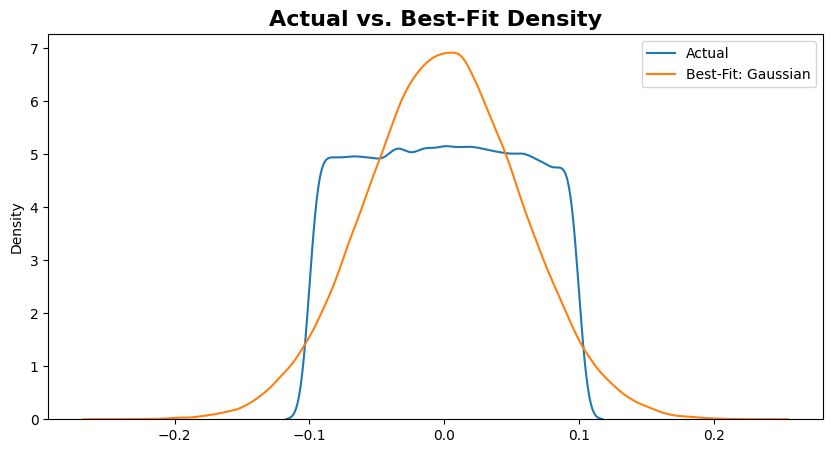

,nll,distribution
rank,,
1,-1.485322e+05,Gaussian
2,-1.484402e+05,StudentT
3,-1.452821e+05,Gumbel
4,-1.353987e+05,Laplace
5,-1.189456e+05,Cauchy
6,-1.074396e+05,Gamma
7,-5.250641e+04,Weibull
8,1.452074e+06,LogNormal


In [4]:
from lightgbmlss.distributions import *
from lightgbmlss.distributions.distribution_utils import DistributionClass
import numpy as np

Y_train_np = np.array(Y_train)

lgblss_dist_class = DistributionClass()
candidate_distributions = [Gaussian, StudentT, Gamma, Cauchy, LogNormal, Weibull, Gumbel, Laplace]

dist_nll = lgblss_dist_class.dist_select(target=Y_train_np, candidate_distributions=candidate_distributions, max_iter=50, plot=True, figure_size=(10, 5))
dist_nll

este grafico apenas ve a distribuição da target variable?

In [5]:
from lightgbmlss.model import *
from lightgbmlss.distributions.Gaussian import *

dtrain = lgb.Dataset(X_train, label=Y_train_np)

lgblss = LightGBMLSS(
    Gaussian(stabilization="None",  
             response_fn="exp",      
             loss_fn="nll"          
            ))

param_dict = { 
    "max_depth":               ["int",   {"low": 1,    "high": 10,    "log": False}],
    "num_leaves":              ["int",   {"low": 2,    "high": 100,   "log": False}],  
    "min_data_in_leaf":        ["int",   {"low": 200,  "high": 200,   "log": False}],  
    "min_gain_to_split":       ["float", {"low": 1, "high": 40,    "log": False}],
    "min_sum_hessian_in_leaf": ["float", {"low": 1, "high": 500,   "log": True}],
    "subsample":               ["float", {"low": 0.2,  "high": 1.0,   "log": False}],
    "feature_fraction":        ["float", {"low": 0.2,  "high": 1.0,   "log": False}],
    "boosting":                ["numerical", ["dart", "goss", "gbdt"]],
}

np.random.seed(123)
opt_param = lgblss.hyper_opt(param_dict,
                             dtrain,
                             num_boost_round=100,        # Number of boosting iterations.
                             nfold=5,                    # Number of cv-folds.
                             early_stopping_rounds=50,   # Number of early-stopping rounds
                             max_minutes=10,             # Time budget in minutes, i.e., stop study after the given number of minutes.
                             n_trials=30 ,               # The number of trials. If this argument is set to None, there is no limitation on the number of trials.
                             silence=True,               # Controls the verbosity of the trail, i.e., user can silence the outputs of the trail.
                             seed=123,                   # Seed used to generate cv-folds.
                             hp_seed=123                 # Seed for random number generator used in the Bayesian hyperparameter search.
                            )

Best trial: 28. Best value: -29708.2: 100%|██████████| 30/30 [02:09<00:00,  4.31s/it, 129.18/600 seconds]


Hyper-Parameter Optimization successfully finished.
  Number of finished trials:  30
  Best trial:
    Value: -29708.17893796682
    Params: 
    max_depth: 3
    num_leaves: 74
    min_data_in_leaf: 200
    min_gain_to_split: 1.0052898835766086
    min_sum_hessian_in_leaf: 53.93280062843333
    subsample: 0.41225748937725126
    feature_fraction: 0.9069769879751212
    boosting: gbdt
    opt_rounds: 10


In [6]:
np.random.seed(123)

opt_params = opt_param.copy()
n_rounds = opt_params["opt_rounds"]
del opt_params["opt_rounds"]

# Train Model with optimized hyperparameters
lgblss.train(opt_params, dtrain, num_boost_round=n_rounds)

# Set seed for reproducibility
torch.manual_seed(123)

# Number of samples to draw from predicted distribution
n_samples = 1000
quant_sel = [0.05, 0.95] # Quantiles to calculate from predicted distribution

# Sample from predicted distribution
pred_samples = lgblss.predict(X_test,
                              pred_type="samples",
                              n_samples=n_samples,
                              seed=123)

# Calculate quantiles from predicted distribution
pred_quantiles = lgblss.predict(X_test,
                                pred_type="quantiles",
                                n_samples=n_samples,
                                quantiles=quant_sel)

# Return predicted distributional parameters
pred_params = lgblss.predict(X_test,
                             pred_type="parameters")

In [7]:
pred_samples.head()

,y_sample0,y_sample1,y_sample2,y_sample3,y_sample4,y_sample5,y_sample6,y_sample7,y_sample8,y_sample9,...,y_sample990,y_sample991,y_sample992,y_sample993,y_sample994,y_sample995,y_sample996,y_sample997,y_sample998,y_sample999
0,0.018999,0.032401,-0.032476,-0.038916,-0.084902,0.042690,0.043352,-0.046723,-0.042915,-0.096320,...,0.113215,-0.020143,0.141170,-0.026718,0.059977,-0.042059,0.028305,-0.058339,0.043696,-0.086991
1,-0.010343,0.106749,-0.037816,-0.005386,-0.000364,-0.005106,0.062624,-0.007057,-0.075230,0.108376,...,0.041683,0.008458,0.066743,-0.094722,0.030143,-0.049672,-0.145504,0.045167,0.045697,-0.082461
2,-0.018090,0.030051,-0.093430,-0.015533,0.002618,0.122170,0.034283,-0.026314,-0.085299,0.041217,...,0.056718,-0.051867,-0.001047,0.114040,0.012943,0.006408,0.016170,0.198439,-0.091096,0.137055
3,-0.034003,-0.097028,0.033386,-0.023131,0.010772,-0.050587,-0.010157,0.059864,-0.117747,0.033246,...,-0.030282,-0.082441,0.002150,0.025422,0.018834,-0.044788,0.039199,0.025383,0.068154,-0.070789
4,0.019555,-0.043454,0.004773,-0.050964,0.007239,0.053043,0.086485,0.108946,0.038866,-0.030205,...,-0.042366,0.027033,0.007319,0.021461,-0.058859,0.030850,-0.005754,-0.000879,-0.003444,0.007543


In [8]:
pred_quantiles.head()

,quant_0.05,quant_0.95
0,-0.096870,0.093658
1,-0.095107,0.096916
2,-0.094313,0.101204
3,-0.095731,0.096551
4,-0.094413,0.102277


In [9]:
pred_params.head()

,loc,scale
0,-0.000368,0.057406
1,-0.000220,0.056944
2,-0.000485,0.058003
3,-0.000459,0.057048
4,-0.000797,0.058381


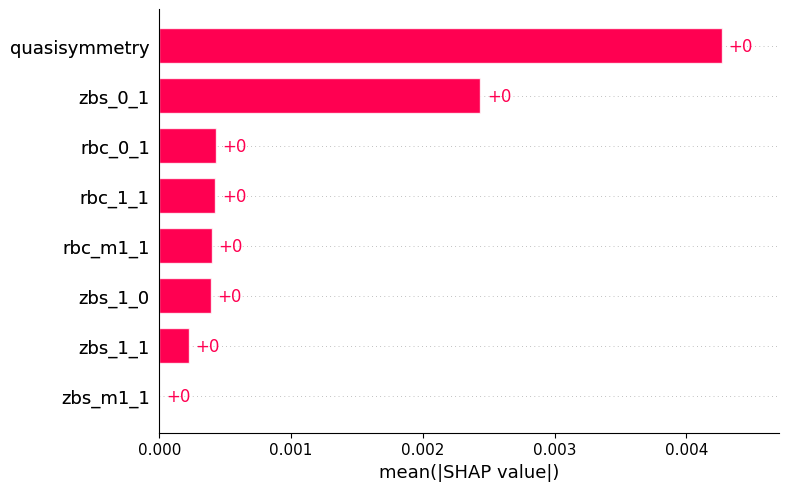

In [10]:
# Feature Importance of scale parameter
lgblss.plot(X_test,
            parameter="scale",
            plot_type="Feature_Importance")

In [11]:
# Assuming Y_test is your true values and pred_params contains mean and variance of the predictions
# Extract mean and variance
predicted_means = pred_params['loc']
predicted_variances = pred_params['scale']

# Calculate standard deviation from variance
predicted_std = np.sqrt(predicted_variances)

# Calculate Mean Absolute Error (MAE) as one option for mean error
mean_error = np.mean(np.abs(predicted_means - Y_test))

# For Mean Squared Error (MSE), use:
# mean_squared_error = np.mean((predicted_means - Y_test) ** 2)

# Output the results
print(f"Mean Error (MAE): {mean_error}")
print(f"Standard Deviation: {predicted_std.mean()}")  # Average standard deviation across all predictions

# Note: The calculation of standard deviation's average might need adjustments based on your specific requirements.


Mean Error (MAE): 0.04934959074397218
Standard Deviation: 0.2392507791519165


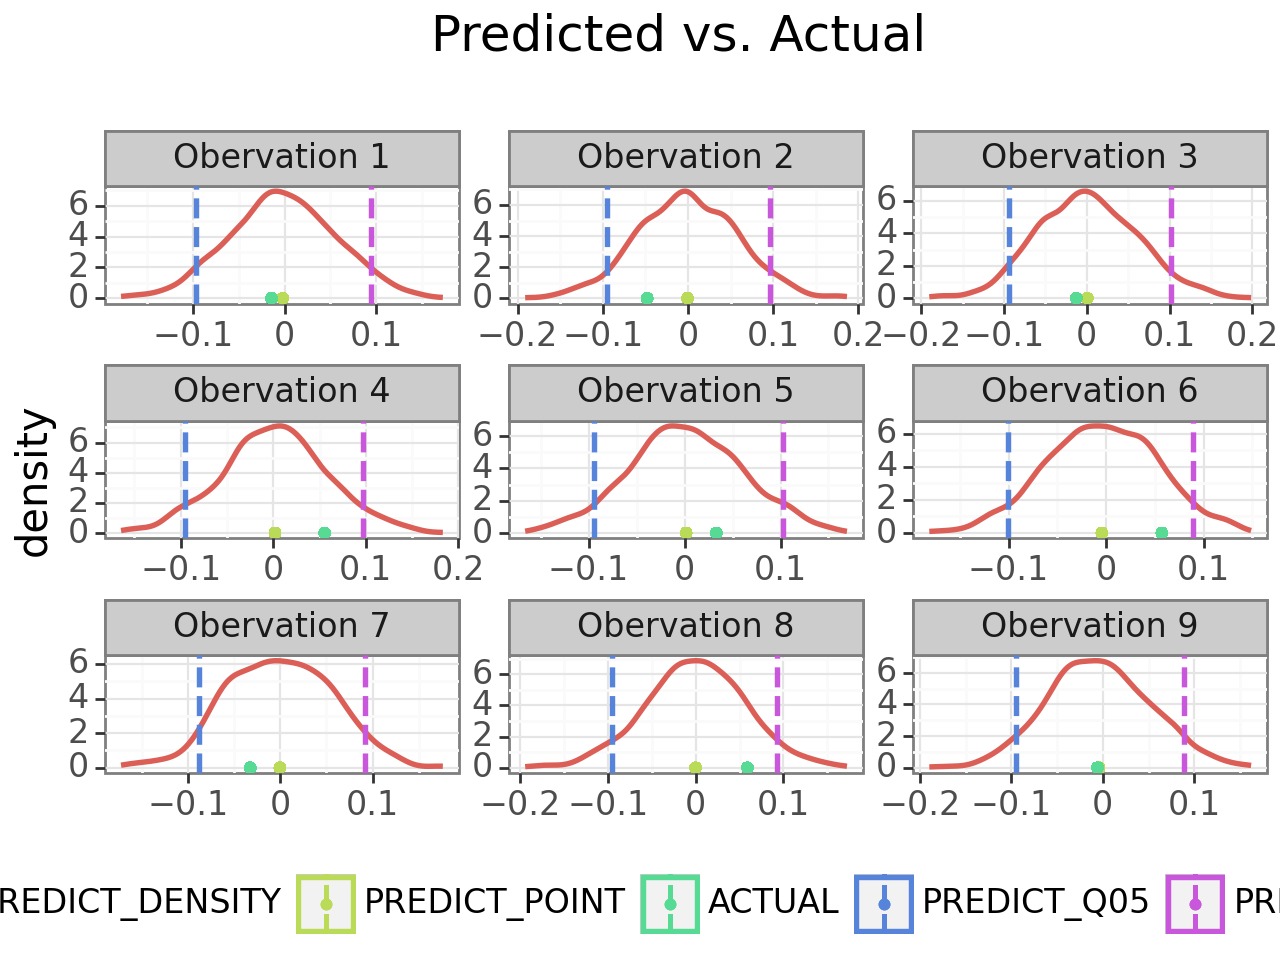

In [12]:
from plotnine import ggplot, aes, geom_point, geom_vline, stat_density, facet_wrap, labs, theme_bw, scale_fill_brewer, theme, element_text, element_blank

y_pred = []

n_examples = 9

for i in range(n_examples):    
    y_samples = pd.DataFrame(pred_samples.values[i,:].reshape(-1,1), columns=["PREDICT_DENSITY"])
    y_samples["PREDICT_POINT"] = y_samples["PREDICT_DENSITY"].mean()
    y_samples["PREDICT_Q05"] = y_samples["PREDICT_DENSITY"].quantile(q=quant_sel[0])
    y_samples["PREDICT_Q95"] = y_samples["PREDICT_DENSITY"].quantile(q=quant_sel[1])
    y_samples["ACTUAL"] = Y_test.iloc[i]
    y_samples["obs"]= f"Obervation {i+1}"
    y_pred.append(y_samples)
    
pred_df = pd.melt(pd.concat(y_pred, axis=0), id_vars="obs")
pred_df["obs"] = pd.Categorical(pred_df["obs"], categories=[f"Obervation {i+1}" for i in range(n_examples)])
df_actual, df_pred_dens, df_pred_point, df_q05, df_q95 = [x for _, x in pred_df.groupby("variable")]

plot_pred = (
    ggplot(pred_df,
           aes(color="variable")) + 
    stat_density(df_pred_dens,
                 aes(x="value"),
                 size=1.1) + 
    geom_point(df_pred_point,
               aes(x="value",
                   y=0),
               size=1.4) + 
    geom_point(df_actual,
               aes(x="value",
                   y=0),
               size=1.4) + 
    geom_vline(df_q05, 
               aes(xintercept="value",
                   fill="variable",
                   color="variable"),
               linetype="dashed",
               size=1.1) + 
    geom_vline(df_q95, 
               aes(xintercept="value",
                   fill="variable",
                   color="variable"),
               linetype="dashed",
               size=1.1) + 
    facet_wrap("obs",
               scales="free",
               ncol=3) + 
    labs(title="Predicted vs. Actual \n",
         x = "") + 
    theme_bw(base_size=15) +
    scale_fill_brewer(type="qual", palette="Dark2") + 
    theme(legend_position="bottom",
          plot_title = element_text(hjust = 0.5),
          legend_title = element_blank()
         )
)

print(plot_pred)

In [13]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

print(features.shape)
# Apply t-SNE to the scaled training features
truncated_df = data_df_clean.truncate(before = 100, after = 1000)

# Apply t-SNE to the features to reduce to 2D for visualization
tsne = TSNE(n_components=2, random_state=9, perplexity=50)
features_reduced = tsne.fit_transform(features)

truncated_pred_means = predicted_means.truncate(before=100, after=1000) # Calculate the mean across columns for each row

# Plotting
plt.figure(figsize=(10, 8))
scatter = plt.scatter(features_reduced[:, 0], features_reduced[:, 1], c=truncated_pred_means, cmap='viridis', alpha=0.6)
plt.colorbar(scatter, label='Mean Value')
plt.title('t-SNE plot colored by Mean Value')
plt.xlabel('t-SNE Feature 1')
plt.ylabel('t-SNE Feature 2')
plt.show()

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:106: RuntimeWarning: overflow encountered in cast


: 